# Testing anomaly detection algorithms on KDDCUP99
The 1998 DARPA Intrusion Detection Evaluation Program was prepared and managed by MIT Lincoln Labs. The objective was to survey and evaluate research in intrusion detection.  A standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment, was provided.  The 1999 KDD intrusion detection contest uses a version of this dataset.

We will evaluate the performance of unsupervised learning algorithms such as Isolation Forest, Local Outlier Factor, Support Vector Machines and DBSCAN against this dataset. Mainly in term of accuracy, runtime and memory consumption.


In [6]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [7]:
def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Reds):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def time(expr):
    start = datetime.datetime.now()
    code = eval(expr)
    end = datetime.datetime.now()
    return (end-start, code)

sa_columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                           "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                           "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
                           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
                           "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                           "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
sf_columns = ["duration", "service", "src_bytes", "dst_bytes"]

# KDDCUP99 SF data set
`SF` is the a subset of the main dataset where the attribute logged_in is positive, thus focusing on the intrusion attack, which gives an anomaly ratio 0.3%. SF has log-transformed 4 attributes.

In [8]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=True, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
f"SF anomaly rate is {anomaly_rate_sf:.1%}"

'SF anomaly rate is 4.5%'


## Data preprocessing for SF
The preprocessing step consists of :
* Encode categorical attributes to numerical using a Label encoder
* Strip the data of its label for unsupervised learning
* Normalize the numerical attributes

In [9]:
dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

dfsf_normed = preprocessing.normalize(dfsf.drop(["target", 'binary_target'], axis=1))

## Initializing algorithms

In [6]:
num_extimators = 100
max_samples = 0.25
contamination = 0.25
eps = 0.25

ifsf = IsolationForest(max_samples=0.25, random_state=1, contamination = contamination, n_estimators=100, n_jobs=-1)
lofsf = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=0.2, n_jobs=-1)
ocsvm = OneClassSVM(nu=contamination, kernel="rbf",gamma=0.1)
dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1)

In [7]:
X_sf = dfsf.drop(["target", 'binary_target'], axis=1)
y_sf = dfsf["binary_target"]

In [8]:
fit_time_if_sf, Y_pred_sf_if  = time(expr = "ifsf.fit_predict(X_sf)")
print(f"Trainning If finished in {fit_time_if_sf}")
cm_sf_if = confusion_matrix(y_sf, Y_pred_sf_if)

Trainning If finished in 0:00:07.865287


In [9]:
fit_time_lof_sf, Y_pred_sf_lof  = time(expr = "lofsf.fit_predict(X_sf)")
print(f"Trainning lof finished in {fit_time_lof_sf}")
cm_sf_lof = confusion_matrix(y_sf, Y_pred_sf_lof)

Trainning lof finished in 0:00:03.437367


In [10]:
fit_time_svm_sf, Y_pred_sf_svm  = time(expr = "ocsvm.fit_predict(X_sf)")
print(f"Trainning svm finished in {fit_time_svm_sf}")
cm_sf_svm = confusion_matrix(y_sf, Y_pred_sf_svm)

Trainning svm finished in 0:03:05.083557


In [11]:
fit_time_dbscan_sf, db  = time(expr = "dbscan.fit(X_sf)")
print(f"Trainning dbscan finished in {fit_time_dbscan_sf}")
labels = db.labels_
y_pred_sf_dbscan = [1 if i != -1 else i for i in labels]
cm_sf_dbscan = confusion_matrix(y_sf, y_pred_sf_dbscan)

Trainning dbscan finished in 0:00:13.136974


              precision    recall  f1-score   support

     anomaly       0.18      1.00      0.31      3298
      normal       1.00      0.79      0.88     69939

    accuracy                           0.80     73237
   macro avg       0.59      0.89      0.59     73237
weighted avg       0.96      0.80      0.85     73237

AUC:  89.3%


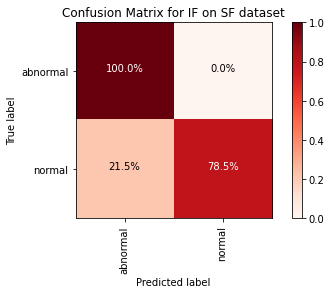

In [12]:
print(classification_report(y_sf, Y_pred_sf_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, Y_pred_sf_if)))
plot_confusion_matrix(cm_sf_if, "Confusion Matrix for IF on SF dataset")

              precision    recall  f1-score   support

     anomaly       0.02      0.07      0.03      3298
      normal       0.95      0.79      0.86     69939

    accuracy                           0.76     73237
   macro avg       0.48      0.43      0.44     73237
weighted avg       0.91      0.76      0.83     73237

AUC:  43.2%


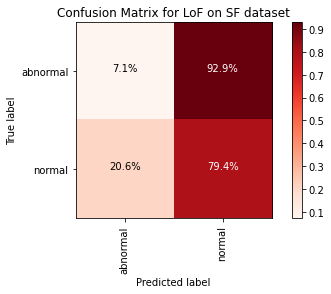

In [13]:
print(classification_report(y_sf, Y_pred_sf_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, Y_pred_sf_lof)))
plot_confusion_matrix(cm_sf_lof, "Confusion Matrix for LoF on SF dataset")

              precision    recall  f1-score   support

     anomaly       0.18      1.00      0.31      3298
      normal       1.00      0.79      0.88     69939

    accuracy                           0.80     73237
   macro avg       0.59      0.89      0.59     73237
weighted avg       0.96      0.80      0.85     73237

AUC:  89.3%


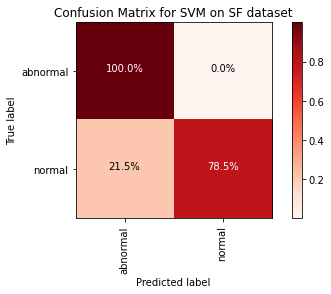

In [14]:
print(classification_report(y_sf, Y_pred_sf_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, Y_pred_sf_svm)))
plot_confusion_matrix(cm_sf_svm, "Confusion Matrix for SVM on SF dataset")

              precision    recall  f1-score   support

     anomaly       0.13      0.04      0.06      3298
      normal       0.96      0.99      0.97     69939

    accuracy                           0.95     73237
   macro avg       0.54      0.51      0.51     73237
weighted avg       0.92      0.95      0.93     73237

AUC:  51.3%


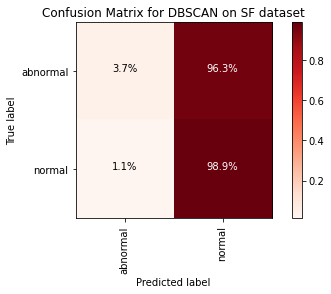

In [15]:
print(classification_report(y_sf, y_pred_sf_dbscan, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, y_pred_sf_dbscan)))
plot_confusion_matrix(cm_sf_dbscan, "Confusion Matrix for DBSCAN on SF dataset")

## Evaluating the algorithms on classifying new data
Frequently we have to classify whether a not a banking transaction or a network traffic is an anomaly in realtime. To evaluate this capabilities, we'll split the dataset into a train and a test set. Our algorithms will train on the train set and then classify the test set

In [16]:
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.33, random_state=0)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(dfsf_normed, dfsf['binary_target'], test_size=0.33, random_state=0)

### SF train set

In [17]:
start = datetime.datetime.now()
y_pred_train_if_sf = ifsf.fit_predict(X_train_sf)
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_if_sf)}")
cm_train_if_sf = confusion_matrix(y_train_sf, y_pred_train_if_sf)

trainning finished in : 0:00:04.934179 : {1, -1}


In [18]:
start = datetime.datetime.now()
y_pred_train_lof_sf = lofsf.fit_predict(X_train_sf)
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_lof_sf)}")
cm_train_lof_sf = confusion_matrix(y_train_sf, y_pred_train_lof_sf)

trainning finished in : 0:00:02.118866 : {1, -1}


In [19]:
start = datetime.datetime.now()
y_pred_train_svm_sf = ocsvm.fit(X_train_sf).predict(X_train_sf)
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_svm_sf)}")
cm_train_svm_sf = confusion_matrix(y_train_sf, y_pred_train_svm_sf)

trainning finished in : 0:01:13.763503 : {1, -1}


In [20]:
start = datetime.datetime.now()
db = dbscan.fit(X_train_sf)
y_pred_train_dbscan_sf = [1 if i != -1 else i for i in db.labels_]
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_dbscan_sf)}")
cm_train_dbscan_sf = confusion_matrix(y_train_sf, y_pred_train_dbscan_sf)

trainning finished in : 0:00:06.555965 : {1, -1}


              precision    recall  f1-score   support

     anomaly       0.18      1.00      0.31      2220
      normal       1.00      0.79      0.88     46848

    accuracy                           0.80     49068
   macro avg       0.59      0.89      0.59     49068
weighted avg       0.96      0.80      0.85     49068

AUC:  89.3%


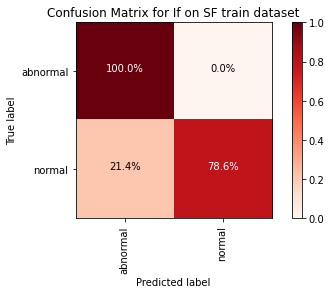

In [21]:
print(classification_report(y_train_sf, y_pred_train_if_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_if_sf)))
plot_confusion_matrix(cm_train_if_sf, "Confusion Matrix for If on SF train dataset")

              precision    recall  f1-score   support

     anomaly       0.02      0.09      0.03      2220
      normal       0.95      0.79      0.86     46848

    accuracy                           0.76     49068
   macro avg       0.48      0.44      0.45     49068
weighted avg       0.91      0.76      0.83     49068

AUC:  44.2%


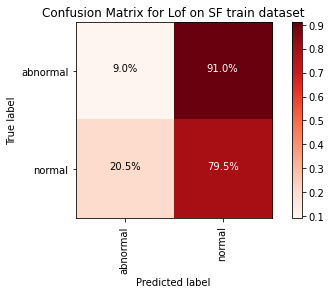

In [22]:
print(classification_report(y_train_sf, y_pred_train_lof_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_lof_sf)))
plot_confusion_matrix(cm_train_lof_sf, "Confusion Matrix for Lof on SF train dataset")

              precision    recall  f1-score   support

     anomaly       0.18      1.00      0.31      2220
      normal       1.00      0.79      0.88     46848

    accuracy                           0.80     49068
   macro avg       0.59      0.89      0.59     49068
weighted avg       0.96      0.80      0.85     49068

AUC:  89.3%


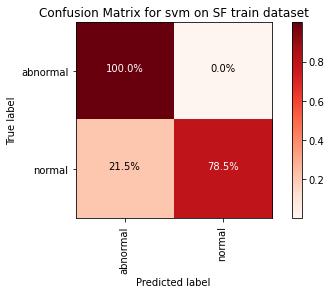

In [23]:
print(classification_report(y_train_sf, y_pred_train_svm_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_svm_sf)))
plot_confusion_matrix(cm_train_svm_sf, "Confusion Matrix for svm on SF train dataset")

              precision    recall  f1-score   support

     anomaly       0.17      0.06      0.09      2220
      normal       0.96      0.99      0.97     46848

    accuracy                           0.94     49068
   macro avg       0.56      0.52      0.53     49068
weighted avg       0.92      0.94      0.93     49068

AUC:  52.2%


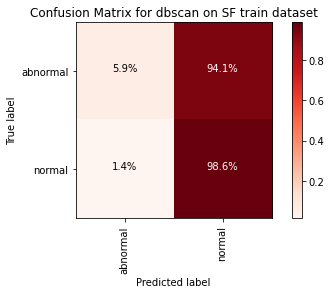

In [24]:
print(classification_report(y_train_sf, y_pred_train_dbscan_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_dbscan_sf)))
plot_confusion_matrix(cm_train_dbscan_sf, "Confusion Matrix for dbscan on SF train dataset")

### SF test set


              precision    recall  f1-score   support

     anomaly       0.18      1.00      0.30      1078
      normal       1.00      0.78      0.88     23091

    accuracy                           0.79     24169
   macro avg       0.59      0.89      0.59     24169
weighted avg       0.96      0.79      0.85     24169

AUC:  89.0%


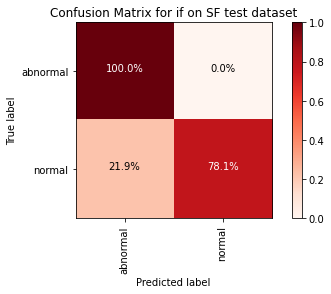

In [25]:
y_pred_test_sf_if = ifsf.predict(X_test_sf)
print(classification_report(y_test_sf, y_pred_test_sf_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_if)))
cm_test_if_sf = confusion_matrix(y_test_sf, y_pred_test_sf_if)
plot_confusion_matrix(cm_test_if_sf, "Confusion Matrix for if on SF test dataset")

              precision    recall  f1-score   support

     anomaly       0.01      0.09      0.02      1078
      normal       0.94      0.71      0.81     23091

    accuracy                           0.69     24169
   macro avg       0.48      0.40      0.42     24169
weighted avg       0.90      0.69      0.78     24169

AUC:  39.9%


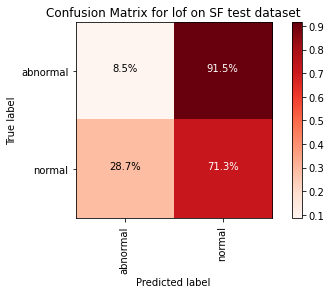

In [26]:
X_clean_sf = X_train_sf.drop([index for i,index in enumerate(y_pred_train_lof_sf) if i==-1])
n_lof = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=contamination, novelty=True, n_jobs=-1)
n_lof.fit(X_clean_sf)

y_pred_test_sf_lof = n_lof.fit(X_clean_sf).predict(X_test_sf)
print(classification_report(y_test_sf, y_pred_test_sf_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_lof)))
cm_test_lof_sf = confusion_matrix(y_test_sf, y_pred_test_sf_lof)
plot_confusion_matrix(cm_test_lof_sf, "Confusion Matrix for lof on SF test dataset")

              precision    recall  f1-score   support

     anomaly       0.18      1.00      0.30      1078
      normal       1.00      0.79      0.88     23091

    accuracy                           0.80     24169
   macro avg       0.59      0.89      0.59     24169
weighted avg       0.96      0.80      0.85     24169

AUC:  89.3%


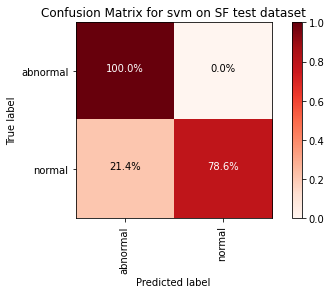

In [27]:
y_pred_test_sf_svm = ocsvm.predict(X_test_sf)
print(classification_report(y_test_sf, y_pred_test_sf_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_svm)))
cm_test_svm_sf = confusion_matrix(y_test_sf, y_pred_test_sf_svm)
plot_confusion_matrix(cm_test_svm_sf, "Confusion Matrix for svm on SF test dataset")

              precision    recall  f1-score   support

     anomaly       0.14      0.06      0.09      1078
      normal       0.96      0.98      0.97     23091

    accuracy                           0.94     24169
   macro avg       0.55      0.52      0.53     24169
weighted avg       0.92      0.94      0.93     24169

AUC:  52.2%


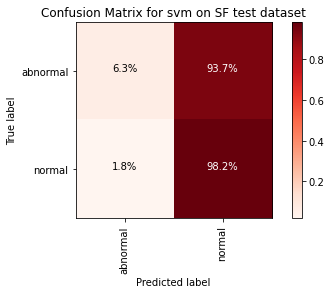

In [28]:
db = dbscan.fit_predict(X_test_sf)
y_pred_test_sf_db = [1 if i != -1 else i for i in db]
print(classification_report(y_test_sf, y_pred_test_sf_db, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_db)))
cm_test_dbscan_sf = confusion_matrix(y_test_sf, y_pred_test_sf_db)
plot_confusion_matrix(cm_test_dbscan_sf, "Confusion Matrix for dbscan on SF test dataset")

# KDDCUP SA dataset

`SA` is obtained by simply selecting all the normal data, and a small proportion of abnormal data to give an anomaly ratio of 1%. SA has all 41 attributes.

Similar to the `SF` dataset, unlabelled data are fed to the anomaly detection algorithms. The results are then compared with the original label to mesure performance.




In [10]:
sa = datasets.fetch_kddcup99(subset='SA', percent10=True)
dfsa=pd.DataFrame(sa.data, 
                  columns=sa_columns)
assert len(dfsa)>0, "SA dataset not loaded."
dfsa["target"]=sa.target
anomaly_rate_sa = 1.0 - len(dfsa.loc[dfsa["target"]==b'normal.'])/len(dfsa)
f"SA anomaly rate is {anomaly_rate_sa:.1%}"

'SA anomaly rate is 3.4%'


## Data preprocessing for SA
The preprocessing step consists of :
* Encode categorical attributes to numerical using a Label encoder
* Strip the data of its label for unsupervised learning
* Normalize the numerical attributes

In [11]:

toDecodeSA = ["protocol_type", "service", "flag", "target"]
dfsa["binary_target"] = [1 if x==b'normal.' else -1 for x in dfsa["target"]]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSA:
    dfsa[f] = list(map(byte_decoder, dfsa[f]))
    dfsa[f] = leSF.fit_transform(dfsa[f])
    
dfsa_normalized = preprocessing.normalize(dfsa.drop(["target", "binary_target"], axis=1))

X_train_sa, X_test_sa, Y_train_sa, Y_test_sa = train_test_split(dfsa.drop(["target", "binary_target"], axis=1), dfsa["binary_target"], test_size=0.33, random_state=0)
X_train_sa_normalized, X_test_sa_normalized, Y_train_sa_normalized, Y_test_sa_normalized = train_test_split(dfsa_normalized, dfsa["binary_target"], test_size=0.33, random_state=0)

In [12]:
contamination = 0.2
max_samples = 0.25
n_estimator = 100
random_state = 12
n_neighbors = 15

If = IsolationForest(max_samples       = max_samples, 
                     contamination     = contamination, 
                     n_estimators      = n_estimator,
                     random_state      = random_state,
                     n_jobs            = -1)

Lof = LocalOutlierFactor(n_neighbors   = n_neighbors, 
                         metric        = 'euclidean', 
                         algorithm     = 'auto', 
                         contamination = contamination, 
                         n_jobs        = -1)

OCSVM = OneClassSVM(gamma              = 'auto',
                    verbose            = True)


In [32]:
fit_time_if_sa, Y_pred_train_sa_if  = time(expr = "If.fit_predict(X_train_sa_normalized)")
print(f"Trainning If finished in {fit_time_if_sa}")
cm_train_sa_if = confusion_matrix(Y_train_sa_normalized, Y_pred_train_sa_if)

Trainning If finished in 0:00:11.242829


In [33]:
fit_time_lof_sa, Y_pred_train_sa_lof = time(expr = "Lof.fit_predict(X_train_sa_normalized)")
print(f"Trainning Lof finished in {fit_time_lof_sa}")
cm_train_sa_lof = confusion_matrix(Y_train_sa_normalized, Y_pred_train_sa_lof)

Trainning Lof finished in 0:00:07.665372


In [ ]:
fit_time, Y_pred_train_sa_svm  = time(expr = "OCSVM.fit_predict(X_train_sa_normalized)")
print(f"Trainning svm finished in {fit_time}")
cm_train_sa_svm = confusion_matrix(Y_train_sa_normalized, Y_pred_train_sa_svm)

[LibSVM]

              precision    recall  f1-score   support

     anomaly       0.17      1.00      0.28      2235
      normal       1.00      0.83      0.91     65203

    accuracy                           0.83     67438
   macro avg       0.58      0.91      0.60     67438
weighted avg       0.97      0.83      0.89     67438

AUC:  91.3%


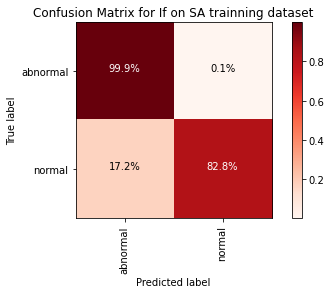

In [42]:
print(classification_report(Y_train_sa_normalized, Y_pred_train_sa_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_train_sa_normalized, Y_pred_train_sa_if)))
plot_confusion_matrix(cm_train_sa_if, "Confusion Matrix for If on SA trainning dataset")

              precision    recall  f1-score   support

     anomaly       0.02      0.11      0.03      2235
      normal       0.96      0.80      0.87     65203

    accuracy                           0.77     67438
   macro avg       0.49      0.45      0.45     67438
weighted avg       0.93      0.77      0.84     67438

AUC:  45.1%


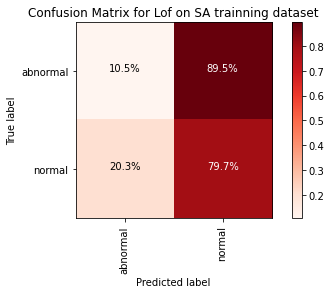

In [43]:

print(classification_report(Y_train_sa_normalized, Y_pred_train_sa_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_train_sa_normalized, Y_pred_train_sa_lof)))
plot_confusion_matrix(cm_train_sa_lof, "Confusion Matrix for Lof on SA trainning dataset")


              precision    recall  f1-score   support

     anomaly       0.07      1.00      0.12      2235
      normal       1.00      0.52      0.68     65203

    accuracy                           0.53     67438
   macro avg       0.53      0.76      0.40     67438
weighted avg       0.97      0.53      0.66     67438

AUC:  75.8%


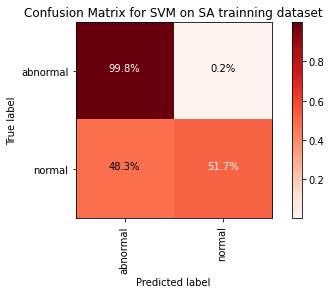

In [41]:
print(classification_report(Y_train_sa_normalized, Y_pred_train_sa_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_train_sa_normalized, Y_pred_train_sa_svm)))
plot_confusion_matrix(cm_train_sa_svm, "Confusion Matrix for SVM on SA trainning dataset")

## SA test set

              precision    recall  f1-score   support

     anomaly       0.17      1.00      0.29      1142
      normal       1.00      0.83      0.91     32075

    accuracy                           0.83     33217
   macro avg       0.59      0.91      0.60     33217
weighted avg       0.97      0.83      0.89     33217

AUC:  91.4%


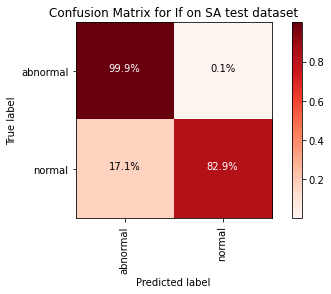

In [44]:
Y_pred_test_sa_if  = If.predict(X_test_sa_normalized)
cm_test_sa_if = confusion_matrix(Y_test_sa_normalized, Y_pred_test_sa_if)

print(classification_report(Y_test_sa_normalized, Y_pred_test_sa_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_test_sa_normalized, Y_pred_test_sa_if)))
plot_confusion_matrix(cm_test_sa_if, "Confusion Matrix for If on SA test dataset")

              precision    recall  f1-score   support

     anomaly       0.02      0.10      0.03      1142
      normal       0.96      0.80      0.87     32075

    accuracy                           0.77     33217
   macro avg       0.49      0.45      0.45     33217
weighted avg       0.93      0.77      0.84     33217

AUC:  44.9%


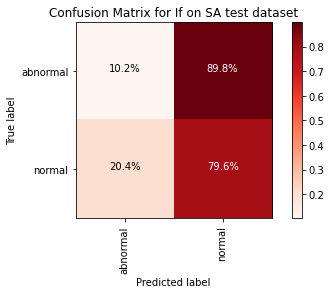

In [45]:
Y_pred_test_sa_lof = Lof.fit_predict(X_test_sa_normalized)
cm_test_sa_lof = confusion_matrix(Y_test_sa_normalized, Y_pred_test_sa_lof)

print(classification_report(Y_test_sa_normalized, Y_pred_test_sa_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_test_sa_normalized, Y_pred_test_sa_lof)))
plot_confusion_matrix(cm_test_sa_lof, "Confusion Matrix for If on SA test dataset")

              precision    recall  f1-score   support

     anomaly       0.07      1.00      0.13      1142
      normal       1.00      0.52      0.68     32075

    accuracy                           0.53     33217
   macro avg       0.53      0.76      0.40     33217
weighted avg       0.97      0.53      0.66     33217

AUC:  75.8%


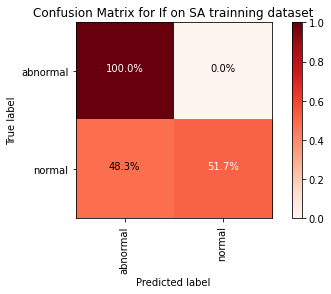

In [46]:
Y_pred_test_sa_svm = OCSVM.predict(X_test_sa_normalized)
cm_test_sa_svm = confusion_matrix(Y_test_sa_normalized, Y_pred_test_sa_svm)


print(classification_report(Y_test_sa_normalized, Y_pred_test_sa_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_test_sa_normalized, Y_pred_test_sa_svm)))
plot_confusion_matrix(cm_test_sa_svm, "Confusion Matrix for If on SA trainning dataset")

In [38]:
def custom_parameter_isolation_forest(max_samples = 0.25, contamination = 0.2, n_estimators = 100, random_state = 0):
    If = IsolationForest(max_samples       = max_samples, 
                     contamination     = contamination, 
                     n_estimators      = n_estimator,
                     random_state      = random_state,
                     n_jobs            = -1)
    
    Y_pred_test_sa_if  = If.fit(X_train_sa_normalized).predict(X_test_sa_normalized)
    return roc_auc_score(Y_test_sa, Y_pred_test_sa_if)

def train_and_predict_lof(contamination = 0.2, n_neighbors = 15):
    Lof = LocalOutlierFactor(n_neighbors   = n_neighbors, 
                          metric        = 'euclidean', 
                          algorithm     = 'auto', 
                          contamination = contamination, 
                          n_jobs        = -1)
    Y_pred  = Lof.fit_predict(X_test_sa_normalized) 
    return roc_auc_score(Y_test_sa, Y_pred)

In [35]:
AUC_if = []
contamination_values = [0.05*x for x in range(1, 6)]
for i in range(4):
  AUC_if.append([custom_parameter_isolation_forest(contamination = c, max_samples = 0.2 + i*0.05) for c in contamination_values])

In [39]:
AUC_lof = []
contamination_values = [0.05*x for x in range(1, 6)]
for i in range(4):
  AUC_lof.append([train_and_predict_lof(n_neighbors = 10 + 5*i, contamination = c) for c in contamination_values])

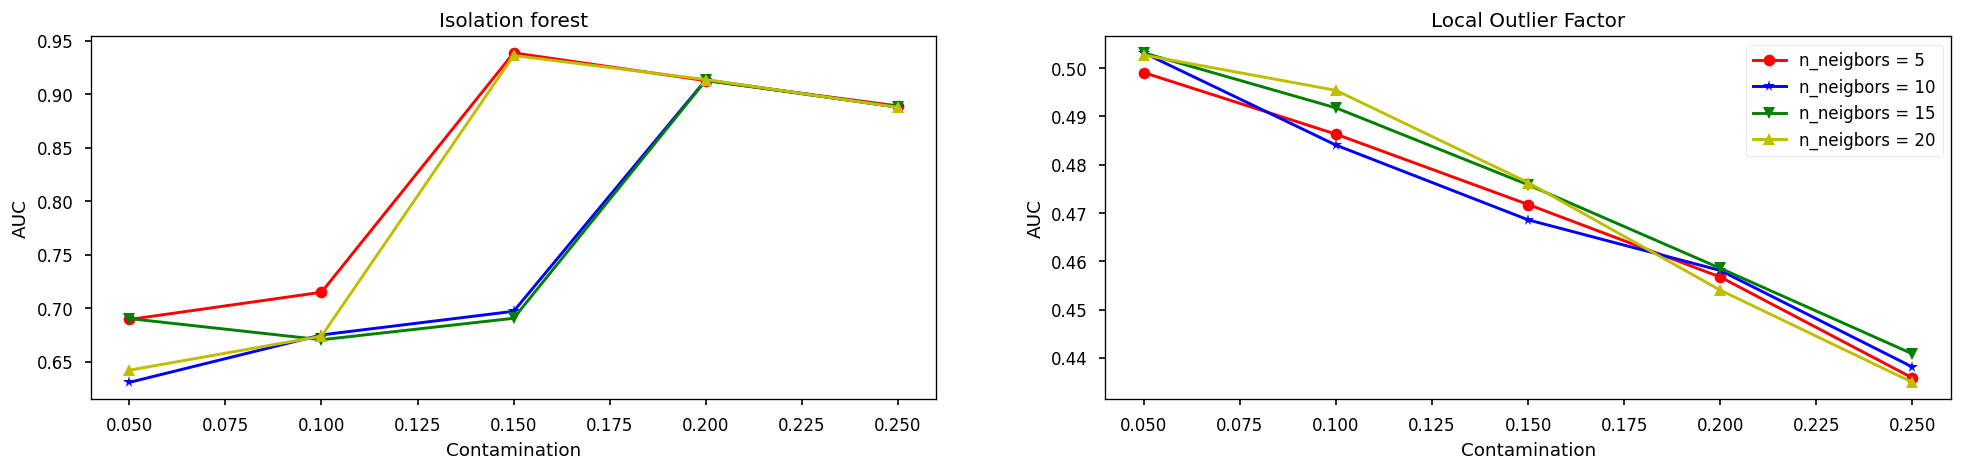

In [40]:
plt.style.use('seaborn-notebook')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4), dpi=120)
for i in range(4):
  ax1.plot(contamination_values, AUC_if[i], marker=['o','*', 'v', '^'][i], color=['r','b','g','y'][i], label=f"max_samples = {0.2 + i*0.05}")
  ax2.plot(contamination_values, AUC_lof[i], marker=['o','*', 'v', '^'][i], color=['r','b','g','y'][i], label=f"n_neigbors = {5 + i*5}")
ax1.set_title('Isolation forest');ax2.set_title('Local Outlier Factor')
ax1.set_xlabel('Contamination');ax2.set_xlabel('Contamination')
ax1.set_ylabel('AUC');ax2.set_ylabel('AUC')
plt.legend()
plt.show()